In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

e:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Initialize all the Constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 10

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\deepi\\Downloads\\Potato Leaf Classification\\Potato Dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
 

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 2 0 0 0 1 1 0 1 1 0 0 1 2 1 1 1 0 1 1 1 0 0 1 0 2 1 0]


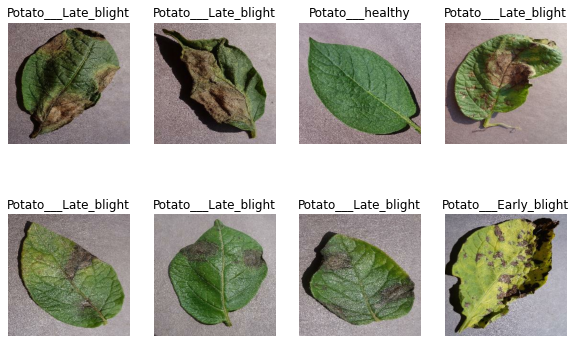

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3,4,1+i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [11]:
len(dataset)

68

### Splitting the Dataset

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [16]:

val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert  (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  val_size = int(val_split * ds_size)
    
  train_ds = ds.take(train_size)    
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
    
  return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

## Shuffle the Data

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

### Resizing and Normalization

In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

### Data Augmentation

In [25]:
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),
])

Augment the Training Dataset also

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Model Building

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compile the Model

In [29]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 [==============================] - 141s 2s/step - loss: 0.8971 - accuracy: 0.5266 - val_loss: 0.8812 - val_accuracy: 0.5052
Epoch 2/10
54/54 [==============================] - 129s 2s/step - loss: 0.7281 - accuracy: 0.6765 - val_loss: 0.6154 - val_accuracy: 0.7344
Epoch 3/10
54/54 [==============================] - 150s 3s/step - loss: 0.4982 - accuracy: 0.7934 - val_loss: 0.4244 - val_accuracy: 0.8438
Epoch 4/10
54/54 [==============================] - 169s 3s/step - loss: 0.3578 - accuracy: 0.8472 - val_loss: 0.3209 - val_accuracy: 0.8333
Epoch 5/10
54/54 [==============================] - 160s 3s/step - loss: 0.2521 - accuracy: 0.8958 - val_loss: 0.1875 - val_accuracy: 0.9375
Epoch 6/10
54/54 [==============================] - 147s 3s/step - loss: 0.2256 - accuracy: 0.9091 - val_loss: 0.2143 - val_accuracy: 0.9115
Epoch 7/10
54/54 [==============================] - 140s 3s/step - loss: 0.1687 - accuracy: 0.9329 - val_loss: 0.1275 - val_accuracy: 0.9479
Epoch 8/10
54

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 14s 717ms/step - loss: 0.1280 - accuracy: 0.9375


We have received an accuracy of 93.75% which is pretty good

In [32]:

scores

[0.12800690531730652, 0.9375]

In [33]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

10

In [37]:
history.history['loss'][:5]

[0.8971489071846008,
 0.7280974984169006,
 0.49820342659950256,
 0.3578074276447296,
 0.2521446645259857]

In [38]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
     

Prediction on a Sample Image

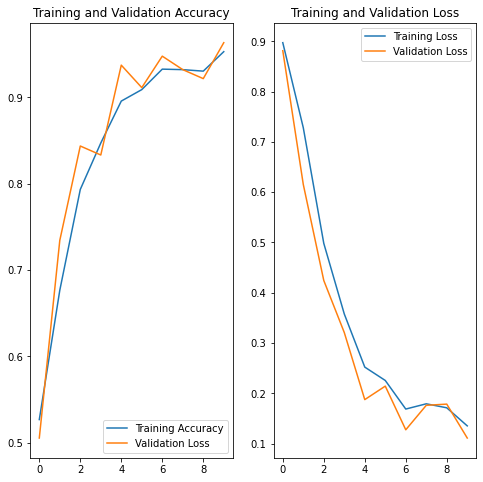

In [39]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 928ms/step
predicted label: Potato___Early_blight


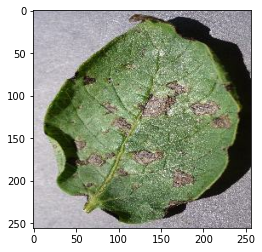

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

Calculate Inference

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 44ms/step


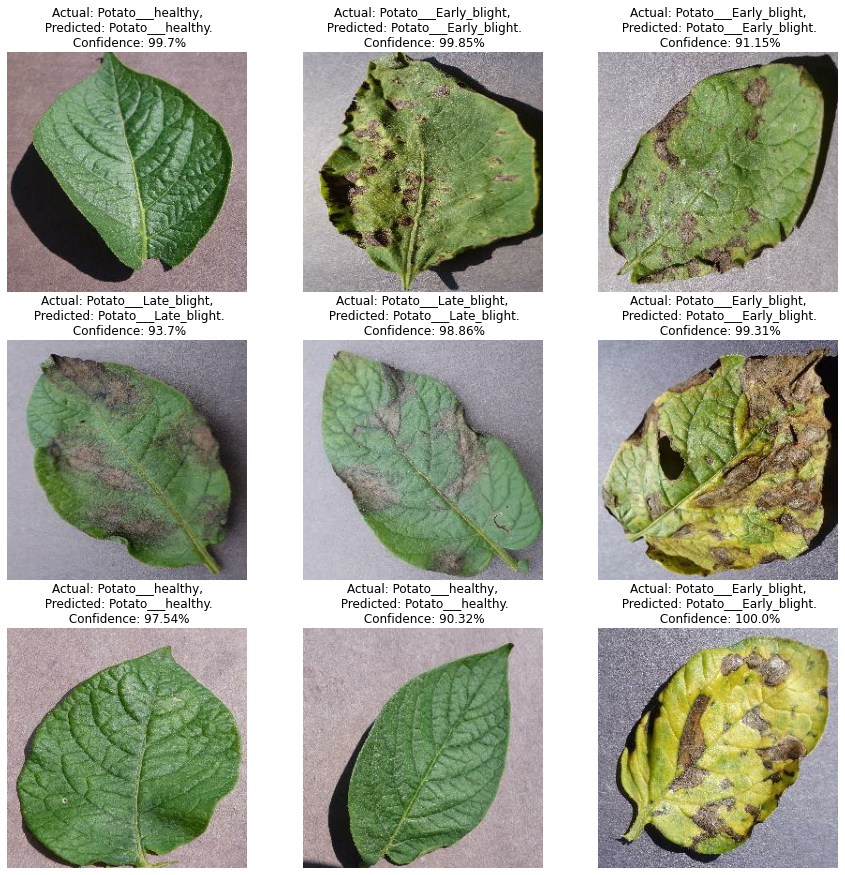

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Perform VGG16 model

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16

In [53]:
base_model = tf.keras.applications.VGG16(
    input_shape=(256,256,3), 
    include_top=False, 
    weights='imagenet'
)

In [55]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, Dropout
from keras.optimizers import Adam

In [56]:
np.random.seed(1)
tf.random.set_seed(1)
model_vgg16 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], name='vgg16_backbone')
model_vgg16.summary()

Model: "vgg16_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 16)                524304    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                    

In [57]:
opt = tf.keras.optimizers.Adam(0.001)
base_model.trainable = False
model_vgg16.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [60]:
%%time 
hist = model_vgg16.fit(train_ds, epochs = 10, validation_data = val_ds, verbose=1)

Epoch 1/10
54/54 [==============================] - 465s 9s/step - loss: 0.2996 - accuracy: 0.7731 - val_loss: 0.3081 - val_accuracy: 0.6979
Epoch 2/10
54/54 [==============================] - 409s 8s/step - loss: 0.1433 - accuracy: 0.8258 - val_loss: -0.0529 - val_accuracy: 0.8073
Epoch 3/10
54/54 [==============================] - 442s 8s/step - loss: 0.0416 - accuracy: 0.8322 - val_loss: -0.2681 - val_accuracy: 0.8750
Epoch 4/10
54/54 [==============================] - 1086s 20s/step - loss: -0.1119 - accuracy: 0.8478 - val_loss: -0.5041 - val_accuracy: 0.8906
Epoch 5/10
54/54 [==============================] - 427s 8s/step - loss: -0.2022 - accuracy: 0.8513 - val_loss: -0.6959 - val_accuracy: 0.9010
Epoch 6/10
54/54 [==============================] - 435s 8s/step - loss: -0.3191 - accuracy: 0.8600 - val_loss: -1.1327 - val_accuracy: 0.8958
Epoch 7/10
54/54 [==============================] - 421s 8s/step - loss: -0.4404 - accuracy: 0.8536 - val_loss: -1.3826 - val_accuracy: 0.8958
E

In [62]:
def plot_hist(hist):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.legend(["Accuracy","Validation Accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.grid()
    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid()
    plt.legend(["Loss","Validation Loss"])
    #plt.suptitle("Model Evaluation")
    plt.tight_layout()
    plt.show()

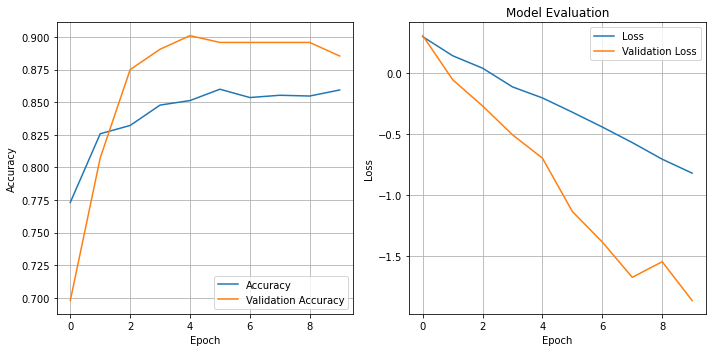

In [63]:
plot_hist(hist)

In [65]:
model_vgg16.save('vgg16model.h5')

In [66]:
# it will save the model
model.save('final_model.h5')